In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom
from skimage.draw import line
import nibabel as nib
import torch
import torchkbnufft as tkbn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

In [2]:
def c2h(X):
    # Convert cartesian to homogeneous coordinates.
    # Input:
    # X - cartesian coordinates
    # Output:
    # Xh - homogeneous coordinates

    n = np.ones([1,X.shape[1]])
    Xh = np.concatenate((X,n))

    return Xh

def t2h(T, t):
    # Convert a 2D transformation matrix to homogeneous form.
    # Input:
    # T - 2D transformation matrix
    # t - 2D translation vector
    # Output:
    # Th - homogeneous transformation matrix

    #------------------------------------------------------------------#
    # TODO: Implement conversion of a transformation matrix and a translation vector to homogeneous transformation matrix.
    #------------------------------------------------------------------#

    #T1 = np.c_[T,t]
    T1 = np.concatenate((T,t[:,None]),axis=1)
    n = np.zeros([1,T1.shape[1]])
    n[-1,-1] = 1
    Th = np.append(T1, n, axis=0)
    
    #print("change output to return Th")
    
    return Th

In [3]:
def identity():
    # 2D identity matrix.
    # Output:
    # T - transformation matrix

    T = np.eye(2)

    return T

def rotate(phi):
    # 2D rotation matrix.
    # Input:
    # phi - rotation angle
    # Output:
    # T - transformation matrix

    #------------------------------------------------------------------#
    # TODO: Implement transformation matrix for rotation.
    #------------------------------------------------------------------#
    
    T = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]])
    
    return T

def image_transform(I, Th,  output_shape=None):
    # Image transformation by inverse mapping.
    # Input:
    # I - image to be transformed
    # Th - homogeneous transformation matrix
    # output_shape - size of the output image (default is same size as input)
    # Output:
    # It - transformed image
	# Xt - remapped coordinates
    # we want double precision for the interpolation, but we want the
    # output to have the same data type as the input - so, we will
    # convert to double and remember the original input type

    input_type = type(I)

    # default output size is same as input
    if output_shape is None:
        output_shape = I.shape

    # spatial coordinates of the transformed image
    x = np.arange(0, output_shape[1])
    y = np.arange(0, output_shape[0])
    xx, yy = np.meshgrid(x, y)

    # convert to a 2-by-p matrix (p is the number of pixels)
    X = np.concatenate((xx.reshape((1, xx.size)), yy.reshape((1, yy.size))))
    # convert to homogeneous coordinates
    Xh = c2h(X)

    #------------------------------------------------------------------#
    # TODO: Perform inverse coordinates mapping.
    #------------------------------------------------------------------#

    T_inv = np.linalg.pinv(Th)
    Xt = T_inv.dot(Xh) 
    It = ndimage.map_coordinates(I, [Xt[1,:], Xt[0,:]], order=1, mode='constant').reshape(output_shape)
    
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if It[i, j] == 0.0:
                It[i, j] = np.min(I)

    return It, Xt

In [4]:
def image_transform_test(I, ang_deg, trans_x, trans_y):

    # rotation around the image center
    centre = int(I.shape[0]/2)
    ang_rad = np.deg2rad(ang_deg)
    T_1 = t2h(identity(), centre*np.ones(2))
    T_2 = t2h(rotate(ang_rad), np.zeros(2))
    T_3 = t2h(identity(), -centre*np.ones(2))
    T_rot = T_1.dot(T_2).dot(T_3)

    # translation
    T_trans = t2h(identity(), np.array([trans_x, trans_y]))
    
    # combine transforms
    T_tot = T_trans.dot(T_rot)
    
    It, Xt = image_transform(I, T_tot)
    
    return It, Xt
    #It1, Xt1 = image_transform(I, T_rot)
    #It2, Xt2 = image_transform(I, T_trans)
    #It3, Xt3 = reg.image_transform(I, T_scale)

    #fig = plt.figure(figsize=(12,5))
    
    #ax1 = fig.add_subplot(131)
    #im1 = ax1.imshow(I)
                          
    #ax2 = fig.add_subplot(132)
    #im2 = ax2.imshow(It1)
    
    #ax3 = fig.add_subplot(133)
    #im3 = ax3.imshow(It2)

    #ax1.set_title('original')
    #ax2.set_title('Rotation')
    #ax3.set_title('Translation')
    
    #return It1, Xt1, It2, Xt2

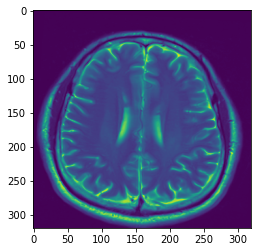

In [20]:
from scipy import ndimage
It, Xt = image_transform_test(image, 3, 5, 7)
plt.imshow(It)

In [21]:
from sklearn.metrics import mean_squared_error
kspace_I = transform_image_to_kspace(image)
kspace_It = transform_image_to_kspace(It)

#img = transform_kspace_to_image(kspace_I)
#It2 = transform_kspace_to_image(kspace_It)
k = np.zeros_like(kspace_I)
k[:179, :] = kspace_I[:179, :]
k[180:, :] = kspace_It[180:, :]

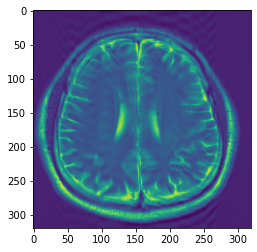

In [22]:
img = transform_kspace_to_image(k)
img = (img - np.mean(img)) / np.std(img)
plt.imshow(img)

In [23]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(image, img)
mse

0.04617604466654619